In [1]:
import numpy as np
import pandas as pd
from scipy import integrate
from superlink.infiltration import GreenAmpt
from superlink.hydraulics import SuperLink
from superlink.simulation import Simulation, interpolate_sample
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('husl')

%matplotlib inline

# Create superlinks and superjunctions representing hillslopes

In [2]:
superjunctions = pd.DataFrame()
superjunctions['name'] = np.arange(20)
superjunctions['id'] = np.arange(20)
superjunctions['z_inv'] = np.repeat([1,0], 10)
superjunctions['h_0'] = 1e-5
superjunctions['bc'] = np.repeat([True, False], 10)
superjunctions['storage'] = 'functional'
superjunctions['a'] = 0.0
superjunctions['b'] = 0.0
superjunctions['c'] = 1e5
superjunctions['max_depth'] = np.inf

In [3]:
superlinks = pd.DataFrame()
superlinks['name'] = np.arange(10)
superlinks['id'] = np.arange(10)
superlinks['sj_0'] = np.arange(10)
superlinks['sj_1'] = np.arange(10, 20)
superlinks['in_offset'] = 0.0
superlinks['out_offset'] = 0.1
superlinks['dx'] = 1000
superlinks['n'] = 0.035
superlinks['shape'] = 'wide'
superlinks['g1'] = 10
superlinks['g2'] = 100
superlinks['g3'] = 0
superlinks['g4'] = 0
superlinks['Q_0'] = 0
superlinks['h_0'] = 1e-5
superlinks['ctrl'] = False
superlinks['A_s'] = 100
superlinks['A_c'] = 0
superlinks['C'] = 0

# Run superlink model to compute overland flow

In [4]:
# Specify subdivisions
njunctions_fixed = 16

In [5]:
# Create model
superlink = SuperLink(superlinks, superjunctions, njunctions_fixed=njunctions_fixed)

In [6]:
# Get surface area of control volumes
surfarea = np.zeros(superlink._kI.size)

first_links = superlink._ik[~superlink._link_end]
last_links = superlink._ik[~superlink._link_start]

surfarea[superlink._I_1k] = (superlink._g2_ik[superlink._i_1k] *
                                    (superlink._dx_ik[superlink._i_1k] / 2))
surfarea[superlink._I_Np1k] = (superlink._g2_ik[superlink._i_nk] *
                                    (superlink._dx_ik[superlink._i_nk] / 2))
surfarea[superlink.middle_nodes] = (superlink._g2_ik[first_links] * superlink._dx_ik[first_links] / 2 
                                    + superlink._g2_ik[last_links] * superlink._dx_ik[last_links] / 2)

# Run Green-Ampt alongside hydraulic solver

In [7]:
n = superlink._kI.size
i = np.linspace(0, 60 / 1000, n)     # Rainfall (m/hr)
Ks = 40 / 1000 * np.ones(n)          # Saturated hydraulic conductivity
theta_s = 0.370 * np.ones(n)         # Saturated soil moisture content
theta_r = 0.025 * np.ones(n)         # Wilting point soil moisture content
theta_i = 0.15 * np.ones(n)          # Initial soil moisture content
lambda_o = 0.474                     # Brooks corey parameter
psi_b = 50/1000                      # Brooks corey suction head
dt = 0.01                            # Time step (hrs)

In [8]:
psi_f = GreenAmpt.suction_head(theta_i, theta_s, theta_r, Ks, psi_b, lambda_o)

In [9]:
ga = GreenAmpt(psi_f, Ks, theta_s, theta_i)

In [10]:
i_sim = np.vstack([np.tile(i, 200).reshape(200, -1), np.zeros((200, n))])

In [11]:
i_sim = pd.DataFrame(i_sim, index=np.arange(0, dt * 400 * 3600, dt * 3600))

In [12]:
F = []
f = []

# Set initial timestep
dt = 10
    
# Create simulation context manager
with Simulation(superlink, dt=dt,
                min_dt=1e-6, max_dt=60, t_end=i_sim.index.values[-1]) as simulation:
    # While simulation time has not expired...
    for step in simulation.steps:
        if simulation.t >= simulation.t_end:
            break
        ga.d = np.maximum(simulation.model._h_Ik, 0)
        i = interpolate_sample(float(simulation.t), i_sim.index.values, i_sim.values)
        ga.step(dt / 3600, i)
        f.append(np.copy(ga.f))
        F.append(np.copy(ga.F))
        Q_Ik = np.maximum((i - ga.f), 0) / 3600 * surfarea
        simulation.step(dt=dt, Q_Ik=Q_Ik)
        # Record internal depth and flow states
        simulation.record_state()
        # Print progress bar
        simulation.print_progress()

[==================================================] 100.0% [10.02 s]

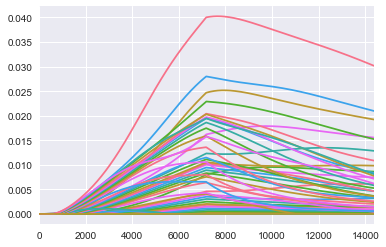

In [13]:
simulation.states._h_Ik.plot(legend=False)

In [14]:
_h_Ik = simulation.states._h_Ik.loc[:, simulation.model._kI >= 7]
_Q_ik = simulation.states._Q_ik.loc[:, simulation.model._ki >= 7]

In [15]:
husl = sns.color_palette(palette='husl', n_colors=3)
kIs = np.repeat(np.arange(3), njunctions_fixed + 1)
kis = np.repeat(np.arange(3), njunctions_fixed)

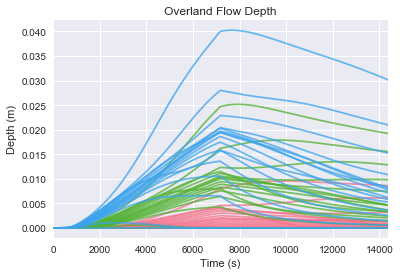

In [16]:
_h_Ik.plot(legend=False, color=[husl[k] for k in kIs], alpha=0.75)
plt.title('Overland Flow Depth')
plt.ylabel('Depth (m)')
_ = plt.xlabel('Time (s)')

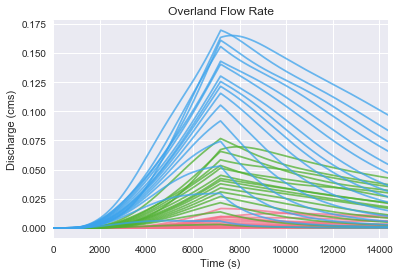

In [17]:
_Q_ik.plot(legend=False, color=[husl[k] for k in kis], alpha=0.75)
plt.title('Overland Flow Rate')
plt.ylabel('Discharge (cms)')
_ = plt.xlabel('Time (s)')

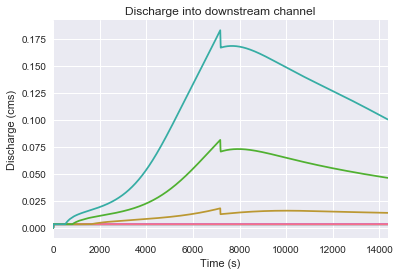

In [18]:
simulation.states._Q_dk.plot(legend=False)
plt.title('Discharge into downstream channel')
plt.ylabel('Discharge (cms)')
_ = plt.xlabel('Time (s)')

Text(0.5, 1.0, 'Infiltration rates')

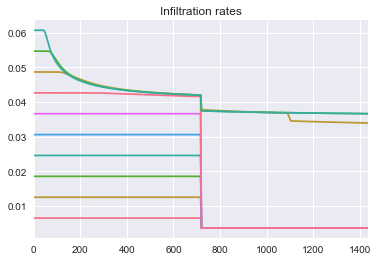

In [19]:
f = np.vstack(f)
pd.DataFrame(f, columns=superlink._kI).T.groupby(level=0).mean().T.plot(legend=False)
plt.title('Infiltration rates')